In [1]:
# %matplotlib widget

from __future__ import annotations

import re
from collections import defaultdict
from dataclasses import dataclass, field
from itertools import permutations, product
from math import inf
from random import choice

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.typing as npt
from mpl_toolkits.mplot3d import axes3d
from numpy import int_, object_
from numpy.typing import NDArray
from test_utilities import run_tests_params
from util import print_hex

COLORS = list(mcolors.CSS4_COLORS.keys())

<link href="style.css" rel="stylesheet"></link>
<article class="day-desc read-aloud"><h2>--- Day 10: The Stars Align ---</h2><p>It's no use; your navigation system simply isn't capable of providing <span title="At the iceberg, use any lane to turn left. Then, swim for eight thousand miles.">walking directions</span> in the arctic circle, and certainly not in 1018.</p>
<p>The Elves suggest an alternative. In times like these, North Pole rescue operations will arrange points of light in the sky to guide missing Elves back to base. Unfortunately, the message is easy to miss: the points move slowly enough that it takes hours to align them, but have so much momentum that they only stay aligned for a second. If you blink at the wrong time, it might be hours before another message appears.</p>
<p>You can see these points of light floating in the distance, and record their position in the sky and their velocity, the relative change in position per second (your puzzle input). The coordinates are all given from your perspective; given enough time, those positions and velocities will move the points into a cohesive message!</p>
<p>Rather than wait, you decide to fast-forward the process and calculate what the points will eventually spell.</p>
<p>For example, suppose you note the following points:</p>
<pre><code>position=&lt; 9,  1&gt; velocity=&lt; 0,  2&gt;
position=&lt; 7,  0&gt; velocity=&lt;-1,  0&gt;
position=&lt; 3, -2&gt; velocity=&lt;-1,  1&gt;
position=&lt; 6, 10&gt; velocity=&lt;-2, -1&gt;
position=&lt; 2, -4&gt; velocity=&lt; 2,  2&gt;
position=&lt;-6, 10&gt; velocity=&lt; 2, -2&gt;
position=&lt; 1,  8&gt; velocity=&lt; 1, -1&gt;
position=&lt; 1,  7&gt; velocity=&lt; 1,  0&gt;
position=&lt;-3, 11&gt; velocity=&lt; 1, -2&gt;
position=&lt; 7,  6&gt; velocity=&lt;-1, -1&gt;
position=&lt;-2,  3&gt; velocity=&lt; 1,  0&gt;
position=&lt;-4,  3&gt; velocity=&lt; 2,  0&gt;
position=&lt;10, -3&gt; velocity=&lt;-1,  1&gt;
position=&lt; 5, 11&gt; velocity=&lt; 1, -2&gt;
position=&lt; 4,  7&gt; velocity=&lt; 0, -1&gt;
position=&lt; 8, -2&gt; velocity=&lt; 0,  1&gt;
position=&lt;15,  0&gt; velocity=&lt;-2,  0&gt;
position=&lt; 1,  6&gt; velocity=&lt; 1,  0&gt;
position=&lt; 8,  9&gt; velocity=&lt; 0, -1&gt;
position=&lt; 3,  3&gt; velocity=&lt;-1,  1&gt;
position=&lt; 0,  5&gt; velocity=&lt; 0, -1&gt;
position=&lt;-2,  2&gt; velocity=&lt; 2,  0&gt;
position=&lt; 5, -2&gt; velocity=&lt; 1,  2&gt;
position=&lt; 1,  4&gt; velocity=&lt; 2,  1&gt;
position=&lt;-2,  7&gt; velocity=&lt; 2, -2&gt;
position=&lt; 3,  6&gt; velocity=&lt;-1, -1&gt;
position=&lt; 5,  0&gt; velocity=&lt; 1,  0&gt;
position=&lt;-6,  0&gt; velocity=&lt; 2,  0&gt;
position=&lt; 5,  9&gt; velocity=&lt; 1, -2&gt;
position=&lt;14,  7&gt; velocity=&lt;-2,  0&gt;
position=&lt;-3,  6&gt; velocity=&lt; 2, -1&gt;
</code></pre>
<p>Each line represents one point. Positions are given as <code>&lt;X, Y&gt;</code> pairs: X represents how far left (negative) or right (positive) the point appears, while Y represents how far up (negative) or down (positive) the point appears.</p>
<p>At <code>0</code> seconds, each point has the position given. Each second, each point's velocity is added to its position. So, a point with velocity <code>&lt;1, -2&gt;</code> is moving to the right, but is moving upward twice as quickly. If this point's initial position were <code>&lt;3, 9&gt;</code>, after <code>3</code> seconds, its position would become <code>&lt;6, 3&gt;</code>.</p>
<p>Over time, the points listed above would move like this:</p>
<pre><code>Initially:
........#.............
................#.....
.........#.#..#.......
......................
#..........#.#.......#
...............#......
....#.................
..#.#....#............
.......#..............
......#...............
...#...#.#...#........
....#..#..#.........#.
.......#..............
...........#..#.......
#...........#.........
...#.......#..........

After 1 second:
......................
......................
..........#....#......
........#.....#.......
..#.........#......#..
......................
......#...............
....##.........#......
......#.#.............
.....##.##..#.........
........#.#...........
........#...#.....#...
..#...........#.......
....#.....#.#.........
......................
......................

After 2 seconds:
......................
......................
......................
..............#.......
....#..#...####..#....
......................
........#....#........
......#.#.............
.......#...#..........
.......#..#..#.#......
....#....#.#..........
.....#...#...##.#.....
........#.............
......................
......................
......................

After 3 seconds:
......................
......................
......................
......................
......#...#..###......
......#...#...#.......
......#...#...#.......
......#####...#.......
......#...#...#.......
......#...#...#.......
......#...#...#.......
......#...#..###......
......................
......................
......................
......................

After 4 seconds:
......................
......................
......................
............#.........
........##...#.#......
......#.....#..#......
.....#..##.##.#.......
.......##.#....#......
...........#....#.....
..............#.......
....#......#...#......
.....#.....##.........
...............#......
...............#......
......................
......................
</code></pre>

<p>After 3 seconds, the message appeared briefly: <code><em>HI</em></code>. Of course, your message will be much longer and will take many more seconds to appear.</p>
<p><em>What message will eventually appear in the sky?</em></p>
</article>


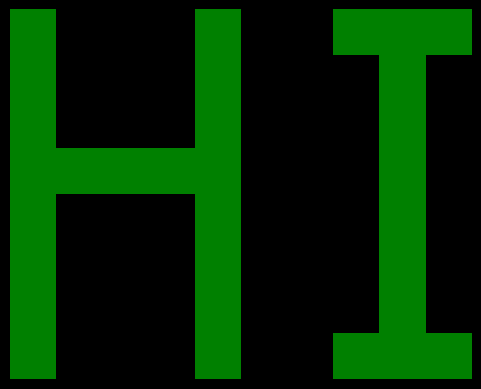

Example did run: 3 should be 3 seconds


In [2]:
from re import findall

from matplotlib import colors
from more_itertools import minmax
from tabulate import tabulate


example = """
position=< 9,  1> velocity=< 0,  2>
position=< 7,  0> velocity=<-1,  0>
position=< 3, -2> velocity=<-1,  1>
position=< 6, 10> velocity=<-2, -1>
position=< 2, -4> velocity=< 2,  2>
position=<-6, 10> velocity=< 2, -2>
position=< 1,  8> velocity=< 1, -1>
position=< 1,  7> velocity=< 1,  0>
position=<-3, 11> velocity=< 1, -2>
position=< 7,  6> velocity=<-1, -1>
position=<-2,  3> velocity=< 1,  0>
position=<-4,  3> velocity=< 2,  0>
position=<10, -3> velocity=<-1,  1>
position=< 5, 11> velocity=< 1, -2>
position=< 4,  7> velocity=< 0, -1>
position=< 8, -2> velocity=< 0,  1>
position=<15,  0> velocity=<-2,  0>
position=< 1,  6> velocity=< 1,  0>
position=< 8,  9> velocity=< 0, -1>
position=< 3,  3> velocity=<-1,  1>
position=< 0,  5> velocity=< 0, -1>
position=<-2,  2> velocity=< 2,  0>
position=< 5, -2> velocity=< 1,  2>
position=< 1,  4> velocity=< 2,  1>
position=<-2,  7> velocity=< 2, -2>
position=< 3,  6> velocity=<-1, -1>
position=< 5,  0> velocity=< 1,  0>
position=<-6,  0> velocity=< 2,  0>
position=< 5,  9> velocity=< 1, -2>
position=<14,  7> velocity=<-2,  0>
position=<-3,  6> velocity=< 2, -1>
"""


def min_chaos(points: list[list[int]]) -> int:
    prev_chaos = inf
    t = 0
    while True:
        points1 = [(x + t * dx, y + t * dy) for x, y, dx, dy in points]
        min_x1, max_x1 = minmax(x for x, *_ in points1)
        min_y1, max_y1 = minmax(y for _, y, *_ in points1)
        chaos = abs(max_x1 - min_x1) * abs(max_y1 - min_y1)
        if chaos > prev_chaos:
            return t - 1
        prev_chaos = chaos
        t += 1


def allign_stars(points_str: str) -> None:
    points = [
        [int(i) for i in findall(r"-?\d+", l)] for l in points_str.strip().splitlines()
    ]

    t = min_chaos(points)

    grid = {(x + t * dx, y + t * dy) for x, y, dx, dy in points}
    min_x, max_x = minmax(x for x, *_ in grid)
    min_y, max_y = minmax(y for _, y, *_ in grid)
    display = [
        [20 if (x, y) in grid else 0 for x in range(min_x, max_x + 1)]
        for y in range(min_y, max_y + 1)
    ]

    cmap = colors.ListedColormap(["black", "green"])
    bounds = [0, 10, 20]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    _, ax = plt.subplots()
    ax.imshow(display, cmap=cmap, norm=norm)
    plt.grid(False)
    plt.axis("off")
    plt.show()
    return t


print(f"Example did run: {allign_stars(example)} should be 3 seconds")

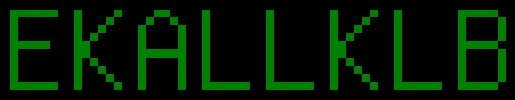

Part I and part II: 10227


In [3]:
with open("../input/day10.txt") as f:
    puzzle = f.read()

print(f"Part I and part II: {allign_stars(puzzle)}")

<link href="style.css" rel="stylesheet"></link>
<main>

<p>Your puzzle answer was <code>EKALLKLB</code>.</p><p class="day-success">The first half of this puzzle is complete! It provides one gold star: *</p>
<article class="day-desc"><h2 id="part2">--- Part Two ---</h2><p>Good thing you didn't have to wait, because that would have taken a long time - much longer than the <code><em>3</em></code> seconds in the example above.</p>
<p>Impressed by your sub-hour communication capabilities, the Elves are curious: <em>exactly how many seconds would they have needed to wait for that message to appear?</em></p>
</article>

<p>Your puzzle answer was <code>10227</code>.</p><p class="day-success">Both parts of this puzzle are complete! They provide two gold stars: **</p>

</main>
